<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/mainJacob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial version

In [9]:
!pip install datasets
!pip install transformers
!pip install deepxde

In [ ]:
# Modules to be loaded and used
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from __future__ import division
from __future__ import print_function

import numpy as np
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import re

## (a)

Compiling model...
Building feed-forward neural network...
'build' took 0.071348 s

'compile' took 0.818250 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.05e+11]    [1.79e+12]    [1.00e+00]    
1000      [3.42e+10]    [7.59e+11]    [6.52e-01]    
2000      [3.21e+10]    [6.84e+11]    [6.19e-01]    
3000      [3.16e+10]    [6.80e+11]    [6.17e-01]    
4000      [3.12e+10]    [6.76e+11]    [6.15e-01]    
5000      [3.07e+10]    [6.72e+11]    [6.13e-01]    
6000      [3.00e+10]    [6.67e+11]    [6.11e-01]    
7000      [2.82e+10]    [6.53e+11]    [6.04e-01]    
8000      [2.02e+10]    [5.84e+11]    [5.71e-01]    
9000      [8.59e+09]    [4.38e+11]    [4.95e-01]    
10000     [2.75e+09]    [3.12e+11]    [4.18e-01]    

Best model at step 10000:
  train loss: 2.75e+09
  test loss: 3.12e+11
  test metric: [4.18e-01]

'train' took 8.950657 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data t

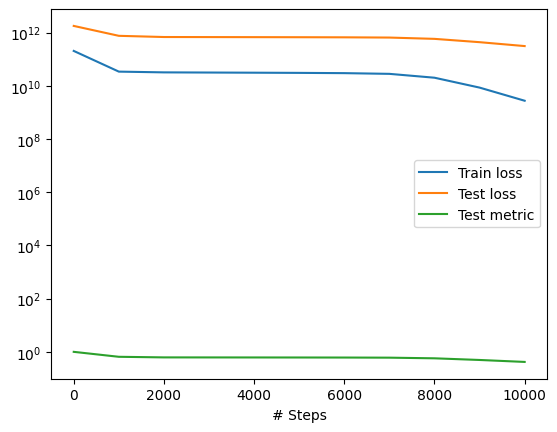

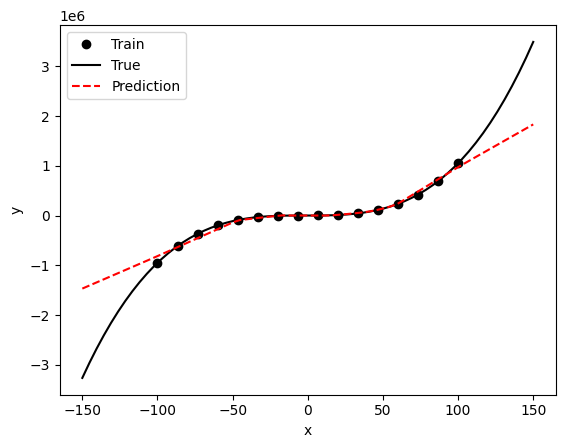

In [58]:
n = 16
a = 1
b = 5
c = 1
X  = np.linspace(-100,100,n)
y  = a*X**3 + b*X**2 + c*X

Xtest  = np.linspace(-150,150,4*n)
ytest  = a*Xtest**3 + b*Xtest**2 + c*Xtest

# function approximation, test outside parameter domain
data2 = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=np.reshape(y, (-1, 1)),
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=np.reshape(ytest, (-1, 1)),
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + 3*[20] + [1]
activation = "relu"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


(c)

Compiling model...
Building feed-forward neural network...
'build' took 0.268810 s

'compile' took 2.701240 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.03e+11]    [8.95e+11]    [1.00e+00]    
1000      [2.22e+10]    [4.32e+11]    [6.95e-01]    
2000      [1.61e+10]    [3.42e+11]    [6.19e-01]    
3000      [1.59e+10]    [3.40e+11]    [6.17e-01]    
4000      [1.57e+10]    [3.39e+11]    [6.15e-01]    
5000      [1.54e+10]    [3.37e+11]    [6.14e-01]    
6000      [1.51e+10]    [3.34e+11]    [6.11e-01]    
7000      [1.43e+10]    [3.28e+11]    [6.05e-01]    
8000      [1.07e+10]    [2.95e+11]    [5.74e-01]    
9000      [6.43e+09]    [2.40e+11]    [5.18e-01]    
10000     [3.18e+09]    [1.87e+11]    [4.57e-01]    

Best model at step 10000:
  train loss: 3.18e+09
  test loss: 1.87e+11
  test metric: [4.57e-01]

'train' took 8.989474 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data t

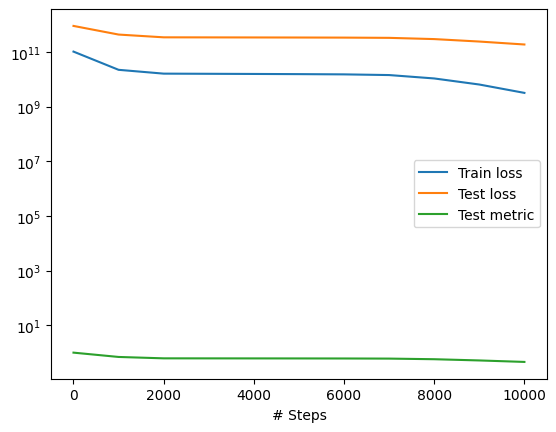

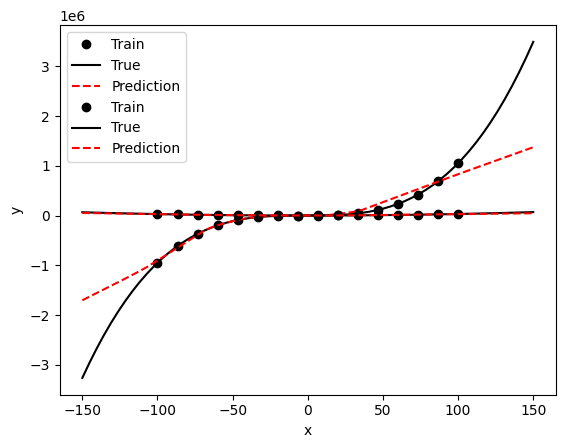

In [57]:
a = 1
b = 5
c = 1
X  = np.linspace(-100,100,n)
y  = [a*X**3 + b*X**2 + c*X, 3*a*X**2 + 2*b*X + c]
Xtest  = np.linspace(-150,150,4*n)
ytest  = [a*Xtest**3 + b*Xtest**2 + c*Xtest, 3*a*Xtest**2 + 2*b*Xtest + c]

# reshaping output training data
y1 = np.asmatrix(y[0]).transpose()
y2 = np.asmatrix(y[1]).transpose()
ynew = np.concatenate((y1,y2),axis=1)
ynew = np.asarray(ynew)

# reshaping output test data
ytest1 = np.asmatrix(ytest[0]).transpose()
ytest2 = np.asmatrix(ytest[1]).transpose()
ytestnew = np.concatenate((ytest1,ytest2),axis=1)
ytestnew = np.asarray(ytestnew)


# function approximation, test outside parameter domain
data2 = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=ynew,
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=ytestnew,
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + [20] * 3 + [2]
activation = "relu"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)